# Exploração de dados

Neste notebook, está contido todo o processo de exploração de dados usados para o desenvolvimento da Wonder Crypto.

In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from sklearn.preprocessing import MinMaxScaler


import datetime as dt
import math

In [18]:
# importing libraries
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import SimpleRNN
from keras.layers import Dropout
from keras.layers import GRU, Bidirectional
from keras.optimizers import SGD
from sklearn import metrics
from sklearn.metrics import mean_squared_error


In [98]:
ticker_symbol = "BTC-USD"

ticker_object = yf.Ticker(ticker_symbol)

btc_values = ticker_object.history(period="2y").drop(columns=['Dividends', 'Stock Splits'])

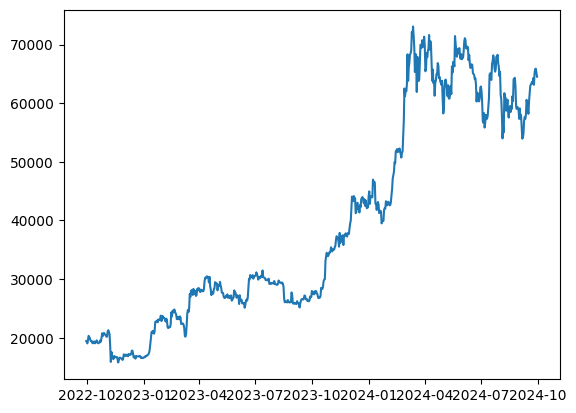

In [99]:
plt.show(plt.plot(btc_values['Close']))

In [100]:
adfuller(btc_values['Close'])

(-0.5150491689190323,
 0.88904614408058,
 20,
 710,
 {'1%': -3.439593802573824,
  '5%': -2.865619356068967,
  '10%': -2.568942332870462},
 12056.94574236885)

In [101]:
adftest = adfuller(btc_values['Close'], autolag='AIC', regression='ct')
print("ADF Test Results")
print("Null Hypothesis: The series is non-stationary")
print("ADF-Statistic:", adftest[0])
print("P-Value:", adftest[1])
print("Number of lags:", adftest[2])
print("Number of observations:", adftest[3])
print("Critical Values:", adftest[4])
print("Note: If P-Value is smaller than 0.05, the series is stationary")

ADF Test Results
Null Hypothesis: The series is non-stationary
ADF-Statistic: -2.0533998685146915
P-Value: 0.5720720188993588
Number of lags: 20
Number of observations: 710
Critical Values: {'1%': -3.9715776134709464, '5%': -3.4166917137612423, '10%': -3.130699538823898}
Note: If P-Value is smaller than 0.05, the series is stationary


In [102]:
btc_values['close_log_values'] = np.log(btc_values['Close'])

btc_values['close_diff_values'] = btc_values['close_log_values'].diff()

btc_values['close_growth_values'] = btc_values['close_diff_values'] * 100

btc_values.head()

,Open,High,Low,Close,Volume,close_log_values,close_diff_values,close_growth_values
Date,,,,,,,,
2022-09-30 00:00:00+00:00,19573.431641,20109.849609,19265.662109,19431.789062,43975248085,9.874666,NaN,NaN
2022-10-01 00:00:00+00:00,19431.105469,19471.154297,19231.082031,19312.095703,18719537670,9.868487,-0.006179,-0.617872
2022-10-02 00:00:00+00:00,19311.849609,19370.308594,18970.621094,19044.107422,20765955327,9.854513,-0.013974,-1.397389
2022-10-03 00:00:00+00:00,19044.068359,19653.542969,19025.226562,19623.580078,30484729489,9.884487,0.029974,2.997418
2022-10-04 00:00:00+00:00,19623.583984,20380.343750,19523.839844,20336.843750,35887278685,9.920189,0.035702,3.570230


In [103]:
adftest = adfuller(btc_values['close_diff_values'].dropna(), autolag='AIC', regression='ct')
print("ADF Test Results")
print("Null Hypothesis: The series is non-stationary")
print("ADF-Statistic:", adftest[0])
print("P-Value:", adftest[1])
print("Number of lags:", adftest[2])
print("Number of observations:", adftest[3])
print("Critical Values:", adftest[4])
print("Note: If P-Value is smaller than 0.05, the series is stationary")

ADF Test Results
Null Hypothesis: The series is non-stationary
ADF-Statistic: -27.907440632321787
P-Value: 0.0
Number of lags: 0
Number of observations: 729
Critical Values: {'1%': -3.9712423570933804, '5%': -3.416529616517029, '10%': -3.1306042197526884}
Note: If P-Value is smaller than 0.05, the series is stationary


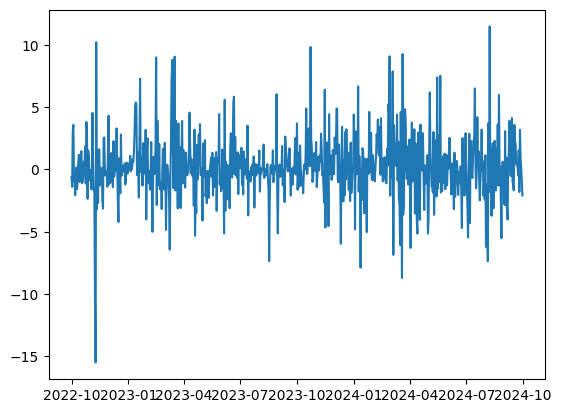

In [104]:
plt.show(plt.plot(btc_values['close_growth_values']))

# Construção de modelos

## Modelo 1

In [105]:
training_data_len = math.ceil(len(btc_values) * 0.8)

train_data = btc_values[:training_data_len].iloc[:,7:8].dropna()

test_data = btc_values[training_data_len:].iloc[:,7:8].dropna()

test_data.head()


,close_growth_values
Date,
2024-05-07 00:00:00+00:00,-1.318193
2024-05-08 00:00:00+00:00,-1.856999
2024-05-09 00:00:00+00:00,2.997731
2024-05-10 00:00:00+00:00,-3.645645
2024-05-11 00:00:00+00:00,0.001536


In [106]:
dataset_train = train_data.close_growth_values.values

dataset_train = np.reshape(dataset_train, (-1,1))

dataset_train.shape

scaler = MinMaxScaler(feature_range=(0,1))
# scaling dataset
scaled_train = scaler.fit_transform(dataset_train)

# Selecting Open Price values
dataset_test = test_data.close_growth_values.values
# Reshaping 1D to 2D array
dataset_test = np.reshape(dataset_test, (-1,1))
# Normalizing values between 0 and 1
scaled_test = scaler.fit_transform(dataset_test)

In [107]:
X_train = []
y_train = []
for i in range(50, len(scaled_train)):
    X_train.append(scaled_train[i-50:i, 0])
    y_train.append(scaled_train[i, 0])
    if i <= 51:
        print(X_train)
        print(y_train)
        print()

X_test = []
y_test = []
for i in range(50, len(scaled_test)):
    X_test.append(scaled_test[i-50:i, 0])
    y_test.append(scaled_test[i, 0])

[array([0.57880587, 0.54846584, 0.7195186 , 0.74181334, 0.56899962,
       0.56302191, 0.52233414, 0.57682605, 0.60883489, 0.5413375 ,
       0.58449742, 0.62445547, 0.64839274, 0.56304338, 0.57883767,
       0.64355925, 0.65953781, 0.5595451 , 0.56342444, 0.58536819,
       0.62703214, 0.61009923, 0.67489103, 0.55855659, 0.75095146,
       0.7313625 , 0.51096843, 0.66179136, 0.64479431, 0.56851399,
       0.57639078, 0.60085994, 0.54046148, 0.61258914, 0.77929365,
       0.62770654, 0.53716069, 0.54218401, 0.19250958, 0.        ,
       1.        , 0.47862278, 0.54876067, 0.49816821, 0.66538086,
       0.6647565 , 0.55293485, 0.60707319, 0.60524663, 0.60606268])]
[0.5038533881219494]

[array([0.57880587, 0.54846584, 0.7195186 , 0.74181334, 0.56899962,
       0.56302191, 0.52233414, 0.57682605, 0.60883489, 0.5413375 ,
       0.58449742, 0.62445547, 0.64839274, 0.56304338, 0.57883767,
       0.64355925, 0.65953781, 0.5595451 , 0.56342444, 0.58536819,
       0.62703214, 0.61009923, 0.674

In [108]:
# The data is converted to Numpy array
X_train, y_train = np.array(X_train), np.array(y_train)

#Reshaping
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1],1))
y_train = np.reshape(y_train, (y_train.shape[0],1))
print("X_train :",X_train.shape,"y_train :",y_train.shape)

# The data is converted to numpy array
X_test, y_test = np.array(X_test), np.array(y_test)

#Reshaping
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1],1))
y_test = np.reshape(y_test, (y_test.shape[0],1))
print("X_test :",X_test.shape,"y_test :",y_test.shape)



X_train : (534, 50, 1) y_train : (534, 1)
X_test : (96, 50, 1) y_test : (96, 1)


In [109]:
# initializing the RNN
regressor = Sequential()

# adding RNN layers and dropout regularization
regressor.add(SimpleRNN(units = 50,
                        activation = "tanh",
                        return_sequences = True,
                        input_shape = (X_train.shape[1],1)))
regressor.add(Dropout(0.2))

regressor.add(SimpleRNN(units = 50,
                        activation = "tanh",
                        return_sequences = True))

regressor.add(SimpleRNN(units = 50,
                        activation = "tanh",
                        return_sequences = True))

regressor.add( SimpleRNN(units = 50))

# adding the output layer
regressor.add(Dense(units = 1,activation='sigmoid'))

# compiling RNN
regressor.compile(optimizer = SGD(learning_rate=0.01,
                                  decay=1e-6,
                                  momentum=0.9,
                                  nesterov=True),
                  loss = "mean_squared_error")

# fitting the model
regressor.fit(X_train, y_train, epochs = 100, batch_size = 2)
regressor.summary()


Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/optimizers/base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


267/267 ━━━━━━━━━━━━━━━━━━━━ 14s 39ms/step - loss: 0.0133
Epoch 2/100
267/267 ━━━━━━━━━━━━━━━━━━━━ 10s 39ms/step - loss: 0.0102
Epoch 3/100
267/267 ━━━━━━━━━━━━━━━━━━━━ 19s 34ms/step - loss: 0.0089
Epoch 4/100
267/267 ━━━━━━━━━━━━━━━━━━━━ 11s 39ms/step - loss: 0.0088
Epoch 5/100
267/267 ━━━━━━━━━━━━━━━━━━━━ 20s 39ms/step - loss: 0.0104
Epoch 6/100
267/267 ━━━━━━━━━━━━━━━━━━━━ 9s 34ms/step - loss: 0.0095
Epoch 7/100
267/267 ━━━━━━━━━━━━━━━━━━━━ 10s 38ms/step - loss: 0.0109
Epoch 8/100
267/267 ━━━━━━━━━━━━━━━━━━━━ 10s 39ms/step - loss: 0.0098
Epoch 9/100
267/267 ━━━━━━━━━━━━━━━━━━━━ 11s 40ms/step - loss: 0.0110
Epoch 10/100
267/267 ━━━━━━━━━━━━━━━━━━━━ 20s 37ms/step - loss: 0.0090
Epoch 11/100
267/267 ━━━━━━━━━━━━━━━━━━━━ 11s 39ms/step - loss: 0.0092
Epoch 12/100
267/267 ━━━━━━━━━━━━━━━━━━━━ 10s 39ms/step - loss: 0.0093
Epoch 13/100
267/267 ━━━━━━━━━━━━━━━━━━━━ 19s 33ms/step - loss: 0.0092
Epoch 14/100
267/267 ━━━━━━━━━━━━━━━━━━━━ 11s 38ms/step - loss: 0.0106
Epoch 15/100
267/267 ━━━━━━━

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ simple_rnn_20 (SimpleRNN)            │ (None, 50, 50)              │           2,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 50, 50)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_21 (SimpleRNN)            │ (None, 50, 50)              │           5,050 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_22 (SimpleRNN)            │ (None, 50, 50)              │           5,050 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_23 (SimpleRNN)            │ (None, 50)                  │           5,050 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 35,604 (139.08 KB)

 Trainable params: 17,801 (69.54 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 17,803 (69.55 KB)

In [110]:
# Salva o modelo completo em um arquivo .h5
regressor.save('meu_modelo_rnn.h5')


In [46]:
#Initialising the model
regressorLSTM = Sequential()

#Adding LSTM layers
regressorLSTM.add(LSTM(50,
                       return_sequences = True,
                       input_shape = (X_train.shape[1],1)))
regressorLSTM.add(LSTM(50,
                       return_sequences = False))
regressorLSTM.add(Dense(25))

#Adding the output layer
regressorLSTM.add(Dense(1))

#Compiling the model
regressorLSTM.compile(optimizer = 'adam',
                      loss = 'mean_squared_error',
                      metrics = ["accuracy"])

#Fitting the model
regressorLSTM.fit(X_train,
                  y_train,
                  batch_size = 1,
                  epochs = 100)
regressorLSTM.summary()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
242/242 ━━━━━━━━━━━━━━━━━━━━ 11s 29ms/step - accuracy: 0.0012 - loss: 0.0356
Epoch 2/100
242/242 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - accuracy: 0.0000e+00 - loss: 0.0228
Epoch 3/100
242/242 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - accuracy: 0.0068 - loss: 0.0207
Epoch 4/100
242/242 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - accuracy: 0.0074 - loss: 0.0260
Epoch 5/100
242/242 ━━━━━━━━━━━━━━━━━━━━ 11s 26ms/step - accuracy: 0.0000e+00 - loss: 0.0248
Epoch 6/100
242/242 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - accuracy: 0.0072 - loss: 0.0202
Epoch 7/100
242/242 ━━━━━━━━━━━━━━━━━━━━ 7s 27ms/step - accuracy: 0.0047 - loss: 0.0215
Epoch 8/100
242/242 ━━━━━━━━━━━━━━━━━━━━ 9s 22ms/step - accuracy: 0.0057 - loss: 0.0229
Epoch 9/100
242/242 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - accuracy: 0.0098 - loss: 0.0204
Epoch 10/100
242/242 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - accuracy: 3.3440e-04 - loss: 0.0260
Epoch 11/100
242/242 ━━━━━━━━━━━━━━━━━━━━ 8s 21ms/step - accuracy: 0.0053 - loss: 0.0235
Epoch 12/100
2

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                        │ (None, 50, 50)              │          10,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_3 (LSTM)                        │ (None, 50)                  │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 25)                  │           1,275 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 1)                   │              26 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 95,705 (373.85 KB)

 Trainable params: 31,901 (124.61 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 63,804 (249.24 KB)

In [47]:
#Initialising the model
regressorGRU = Sequential()

# GRU layers with Dropout regularisation
regressorGRU.add(GRU(units=50,
                     return_sequences=True,
                     input_shape=(X_train.shape[1],1),
                     activation='tanh'))
regressorGRU.add(Dropout(0.2))

regressorGRU.add(GRU(units=50,
                     return_sequences=True,
                     activation='tanh'))

regressorGRU.add(GRU(units=50,
                     return_sequences=True,
                     activation='tanh'))

regressorGRU.add(GRU(units=50,
                     activation='tanh'))

# The output layer
regressorGRU.add(Dense(units=1,
                       activation='relu'))
# Compiling the RNN
regressorGRU.compile(optimizer=SGD(learning_rate=0.01,
                                   decay=1e-7,
                                   momentum=0.9,
                                   nesterov=False),
                     loss='mean_squared_error')

# Fitting the data
regressorGRU.fit(X_train,y_train,epochs=100,batch_size=1)
regressorGRU.summary()


Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/optimizers/base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


242/242 ━━━━━━━━━━━━━━━━━━━━ 18s 50ms/step - loss: 0.0482
Epoch 2/100
242/242 ━━━━━━━━━━━━━━━━━━━━ 12s 48ms/step - loss: 0.0306
Epoch 3/100
242/242 ━━━━━━━━━━━━━━━━━━━━ 21s 50ms/step - loss: 0.0245
Epoch 4/100
242/242 ━━━━━━━━━━━━━━━━━━━━ 20s 50ms/step - loss: 0.0221
Epoch 5/100
242/242 ━━━━━━━━━━━━━━━━━━━━ 12s 51ms/step - loss: 0.0241
Epoch 6/100
242/242 ━━━━━━━━━━━━━━━━━━━━ 21s 51ms/step - loss: 0.0219
Epoch 7/100
242/242 ━━━━━━━━━━━━━━━━━━━━ 20s 50ms/step - loss: 0.0251
Epoch 8/100
242/242 ━━━━━━━━━━━━━━━━━━━━ 21s 53ms/step - loss: 0.0231
Epoch 9/100
242/242 ━━━━━━━━━━━━━━━━━━━━ 20s 52ms/step - loss: 0.0221
Epoch 10/100
242/242 ━━━━━━━━━━━━━━━━━━━━ 20s 48ms/step - loss: 0.0249
Epoch 11/100
242/242 ━━━━━━━━━━━━━━━━━━━━ 21s 49ms/step - loss: 0.0294
Epoch 12/100
242/242 ━━━━━━━━━━━━━━━━━━━━ 20s 47ms/step - loss: 0.0235
Epoch 13/100
242/242 ━━━━━━━━━━━━━━━━━━━━ 21s 50ms/step - loss: 0.0252
Epoch 14/100
242/242 ━━━━━━━━━━━━━━━━━━━━ 12s 49ms/step - loss: 0.0233
Epoch 15/100
242/242 ━━━━━━

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ gru_4 (GRU)                          │ (None, 50, 50)              │           7,950 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 50, 50)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_5 (GRU)                          │ (None, 50, 50)              │          15,300 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_6 (GRU)                          │ (None, 50, 50)              │          15,300 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_7 (GRU)                          │ (None, 50)                  │          15,300 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 107,804 (421.11 KB)

 Trainable params: 53,901 (210.55 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 53,903 (210.56 KB)

In [111]:
# predictions with X_test data
y_RNN = regressor.predict(X_test)
y_LSTM = regressorLSTM.predict(X_test)
y_GRU = regressorGRU.predict(X_test)


# scaling back from 0-1 to original
y_RNN_O = scaler.inverse_transform(y_RNN)
y_LSTM_O = scaler.inverse_transform(y_LSTM)
y_GRU_O = scaler.inverse_transform(y_GRU)


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step 


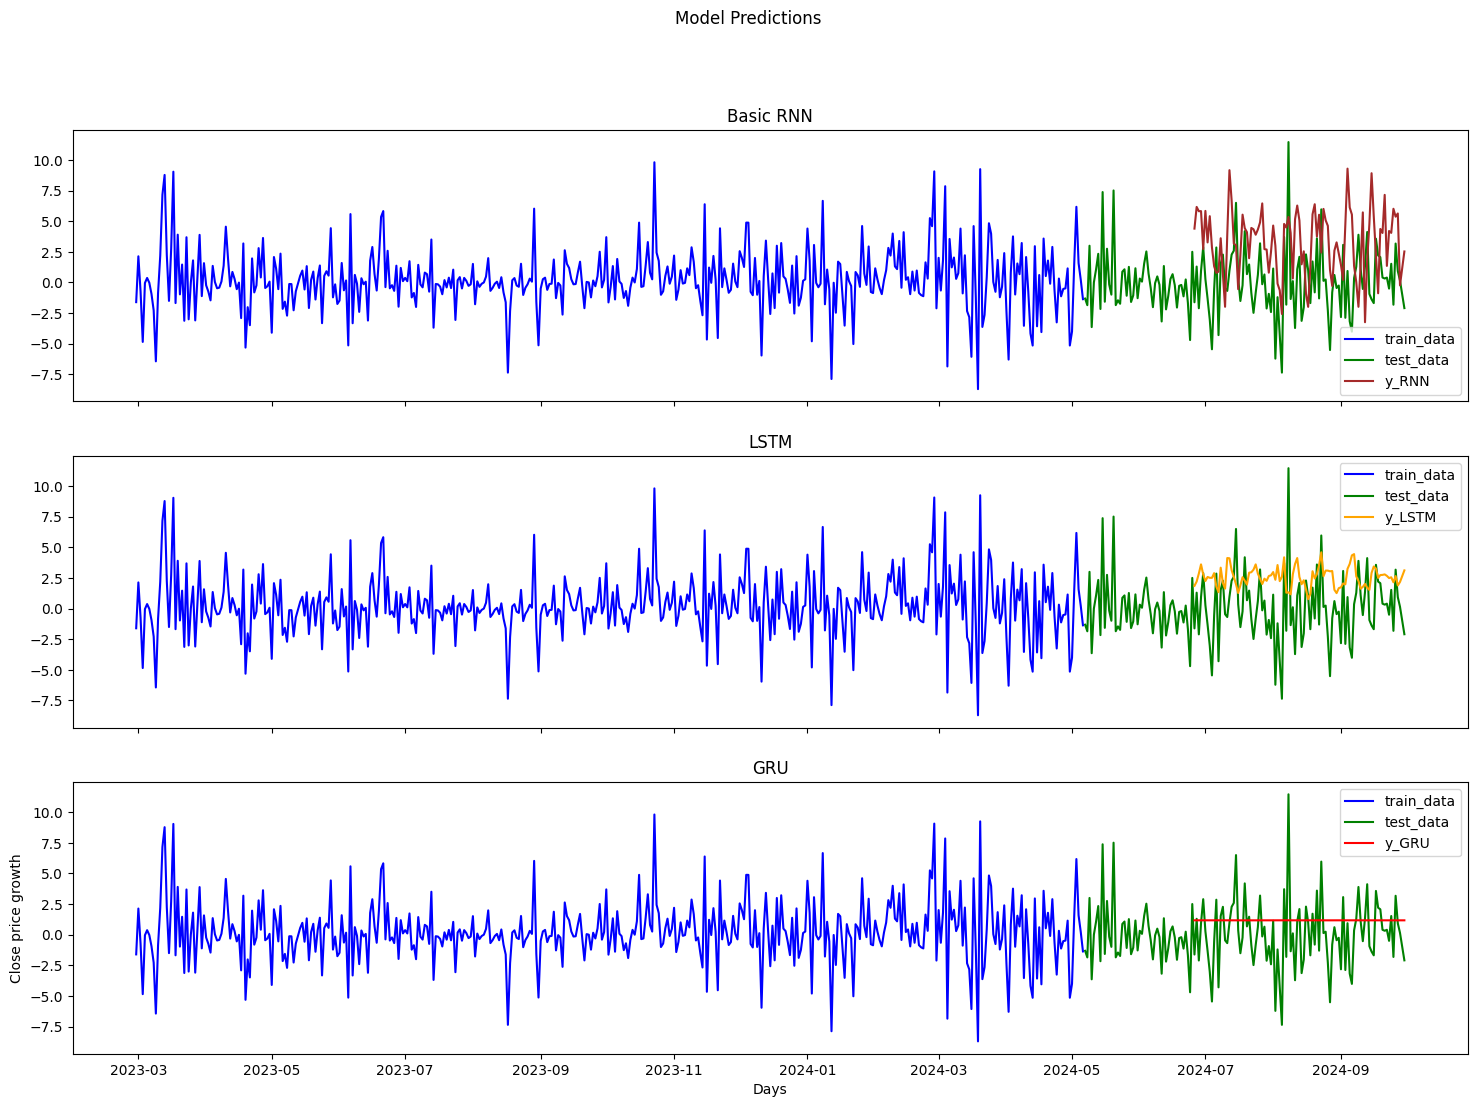

In [112]:
fig, axs = plt.subplots(3,figsize =(18,12),sharex=True, sharey=True)
fig.suptitle('Model Predictions')

#Plot for RNN predictions
axs[0].plot(train_data.index[150:], train_data.close_growth_values[150:], label = "train_data", color = "b")
axs[0].plot(test_data.index, test_data.close_growth_values, label = "test_data", color = "g")
axs[0].plot(test_data.index[50:], y_RNN_O, label = "y_RNN", color = "brown")
axs[0].legend()
axs[0].title.set_text("Basic RNN")

#Plot for LSTM predictions
axs[1].plot(train_data.index[150:], train_data.close_growth_values[150:], label = "train_data", color = "b")
axs[1].plot(test_data.index, test_data.close_growth_values, label = "test_data", color = "g")
axs[1].plot(test_data.index[50:], y_LSTM_O, label = "y_LSTM", color = "orange")
axs[1].legend()
axs[1].title.set_text("LSTM")

#Plot for GRU predictions
axs[2].plot(train_data.index[150:], train_data.close_growth_values[150:], label = "train_data", color = "b")
axs[2].plot(test_data.index, test_data.close_growth_values, label = "test_data", color = "g")
axs[2].plot(test_data.index[50:], y_GRU_O, label = "y_GRU", color = "red")
axs[2].legend()
axs[2].title.set_text("GRU")

plt.xlabel("Days")
plt.ylabel("Close price growth")

plt.show()
